In [ ]:
%cd /content/drive/MyDrive/Colab_Notebooks/Multisession-Chatbot/

/content/drive/MyDrive/Colab_Notebooks/Multisession-Chatbot


In [ ]:
!pip install seaborn

In [ ]:
import os
import gc
import json
import errno
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from os.path import join as pjoin
from glob import iglob
from shutil import rmtree
from tqdm import tqdm

In [ ]:
def mkdir_p(path):
    try:
        os.makedirs(path)
    except OSError as exc:
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise
def del_folder(path):
    try:
        rmtree(path)
    except:
        pass

In [ ]:
def save_parquet(df, save_path):
    df.to_parquet(f'{save_path}.parquet')
    del df
    gc.collect()
    print(save_path, 'Done.')

In [ ]:
ORIGIN = "nia_zip"

ROOT = "chat_data"
DATA = pjoin(ROOT, "origin")
TRAIN_DATA = pjoin(DATA, "train")
TEST_DATA = pjoin(DATA, "test")
VALID_DATA = pjoin(DATA, "valid")

PROC_DATA = pjoin(ROOT, "proc")
PROC_TRAIN_DATA = pjoin(PROC_DATA, "train")
PROC_TEST_DATA = pjoin(PROC_DATA, "test")
PROC_VALID_DATA = pjoin(PROC_DATA, "valid")

SINGLE_DATA = pjoin(ROOT, "singleturn")

In [ ]:
mkdir_p(ROOT)
mkdir_p(DATA)
mkdir_p(TRAIN_DATA)
mkdir_p(TEST_DATA)
mkdir_p(VALID_DATA)

mkdir_p(PROC_DATA)
mkdir_p(PROC_TRAIN_DATA)
mkdir_p(PROC_TEST_DATA)
mkdir_p(PROC_VALID_DATA)

In [ ]:
P = {
    'valid' : 'validation/format_train',
    'test' : 'validation/format_test',
    'train' : 'train'
}

### **DataFrame 형태로 변환**

In [ ]:
mkdir_p(DATA)

for dir_p in list(iglob(pjoin(ORIGIN, "session_**/"))):
    sess_lv = dir_p.split("/")[-2]
    print(sess_lv)

    for d_type in ['train', 'valid', 'test']:
        dtype_dir_p = pjoin(DATA, d_type)
        mkdir_p(dtype_dir_p)
        
        df = pd.DataFrame()
        chat_paths = list(iglob(pjoin(dir_p, f"{P[d_type]}/**.json")))
        print(d_type, len(chat_paths))

        for chat_p in tqdm(chat_paths, desc=f"{sess_lv}", total=len(chat_paths)):
            with open(chat_p, encoding="UTF-8") as f:
                chat = json.load(f)
                filename = chat["FileInfo"]["filename"]
                
                for sess in chat['sessionInfo']:
                    sess_id = sess['sessionID']
                    prev_sess_id = sess['prevSessionID']
                    prev_time = sess['prevTimeInfo']['timeNum'] + sess['prevTimeInfo']['timeUnit']
                    
                    for utt in sess['dialog']:                    
                        row = {
                            "filename" : filename,
                            "sess_id" : sess_id,
                            "prev_sess_id" : prev_sess_id,
                            "prev_time" : prev_time,
                            "speaker" : utt['speaker'],
                            "speaker_id" : utt['personaID'],
                            "utter" : utt['utterance'],
                            "terminate" : utt['terminate'] == "true",
                        }
                        df = df.append(row, ignore_index=True)
        
        save_parquet(df, pjoin(dtype_dir_p, sess_lv))

session_4
valid 250


session_4:   0%|          | 0/250 [00:00<?, ?it/s]

chat_data/valid/session_4 Done.
test 250


session_4:   0%|          | 0/250 [00:00<?, ?it/s]

chat_data/test/session_4 Done.
session_3
valid 250


session_3:   0%|          | 0/250 [00:00<?, ?it/s]

chat_data/valid/session_3 Done.
test 250


session_3:   0%|          | 0/250 [00:00<?, ?it/s]

chat_data/test/session_3 Done.
session_2
valid 200


session_2:   0%|          | 0/200 [00:00<?, ?it/s]

chat_data/valid/session_2 Done.
test 200


session_2:   0%|          | 0/200 [00:00<?, ?it/s]

chat_data/test/session_2 Done.


### **Turn 개수 분포 시각화**

In [ ]:
session_turn_df = pd.DataFrame()

for path in list(iglob(pjoin(DATA, "**/**.parquet"))):
    sess_num = path.split("/")[-1].split(".")[0]
    sess_data = pd.read_parquet(path)

    for sess_id in tqdm(sess_data['sess_id'].unique(), desc=path):
        sess = sess_data[sess_data['sess_id'] == sess_id]
        row = {
            'filename' : path,
            'sess_id' : sess_id,
            'n_turn' : len(sess),
        }
        session_turn_df = session_turn_df.append(row, ignore_index=True)

In [ ]:
plt.figure(figsize=(20, 10))
sns.distplot(session_turn_df['n_turn'])
plt.show()

In [ ]:
min(session_turn_df['n_turn']), max(session_turn_df['n_turn'])

### **이상치 데이터 확인**

턴 개수가 20개 이상인 대화 데이터 확인

In [ ]:
session_turn_df.describe()

턴 개수가 20개 초과인 대화세션은 전체 2%

In [ ]:
len(session_turn_df[session_turn_df['n_turn'] > 20]) / len(session_turn_df)

In [ ]:
session_turn_df[session_turn_df['n_turn'] > 20]

## **대화 데이터 전처리**

한 화자의 발화가 연속적으로 나오는 경우, 한 개의 발화로 취급  

In [ ]:
proc_df = pd.DataFrame()

for dir_type in ['train', 'test', 'valid']:
    for path in list(iglob(pjoin(DATA, f"{dir_type}/**.parquet"))):
        new_path = path.replace('origin', 'proc')    
        sess_data = pd.read_parquet(path)

        for sess_id in tqdm(sess_data['sess_id'].unique(), desc=path):
            sess = sess_data[sess_data['sess_id'] == sess_id]

            i = 0
            while i < len(sess):
                cur_row = sess.iloc[i]
                cur_utt = cur_row['utter']

                i += 1
                while i < len(sess) and sess.iloc[i]['speaker_id'] == cur_row['speaker_id']:
                    try:
                        cur_utt += "<u>" + sess.iloc[i]['utter']
                    except Exception:
                        pass
                    i += 1

                row = {
                    'filename' : cur_row['filename'],
                    'prev_sess_id' : cur_row['prev_sess_id'],
                    'prev_time' : cur_row['prev_time'],
                    'sess_id' : sess_id,
                    'speaker' : cur_row['speaker'],
                    'speaker_id' : cur_row['speaker_id'],
                    'terminate' : cur_row['terminate'],
                    'utter' : cur_utt,
                }
                proc_df = proc_df.append(row, ignore_index=True)
        
        try:
            save_parquet(proc_df, new_path.split(".")[0])
        except:
            proc_df.to_csv(new_path.split(".")[0] + ".csv", index=False)
        proc_df = pd.DataFrame()

chat_data/origin/test/session_4.parquet:   0%|          | 0/209 [00:00<?, ?it/s]

chat_data/proc/test/session_4 Done.


chat_data/origin/test/session_3.parquet:   0%|          | 0/216 [00:00<?, ?it/s]

chat_data/proc/test/session_3 Done.


chat_data/origin/test/session_2.parquet:   0%|          | 0/162 [00:00<?, ?it/s]

chat_data/proc/test/session_2 Done.


chat_data/origin/valid/session_4.parquet:   0%|          | 0/1000 [00:00<?, ?it/s]

chat_data/proc/valid/session_4 Done.


chat_data/origin/valid/session_3.parquet:   0%|          | 0/750 [00:00<?, ?it/s]

chat_data/proc/valid/session_3 Done.


chat_data/origin/valid/session_2.parquet:   0%|          | 0/400 [00:00<?, ?it/s]

chat_data/proc/valid/session_2 Done.


## **싱글턴 대화 데이터셋 구축**

In [ ]:
sturn_df = pd.DataFrame()

for dir_type in ['valid', 'test', 'train']:
    for path in list(iglob(pjoin(PROC_DATA, f"{dir_type}/**.parquet"))):
        sess_data = pd.read_parquet(path)

        for sess_id in tqdm(sess_data['sess_id'].unique(), desc=path):
            sess = sess_data[sess_data['sess_id'] == sess_id]

            for i in range(0, len(sess), 2):
                try:
                    query = sess.iloc[i]
                    reply = sess.iloc[i + 1]

                except Exception:
                    continue
                row = {
                    'type' : dir_type,
                    'sess_id' : sess_id,
                    'speaker_1_id' : query['speaker_id'],
                    'query' : query['utter'],
                    'speaker_2_id' : reply['speaker_id'],
                    'reply' : reply['utter'],
                }
                sturn_df = sturn_df.append(row, ignore_index=True)

    save_parquet(sturn_df, pjoin("chat_data/singleturn", f"{dir_type}"))
    sturn_df = pd.DataFrame()

chat_data/proc/train/session_2.parquet:   0%|          | 0/20000 [00:00<?, ?it/s]

chat_data/singleturn/train Done.


## **발화 길이 분석**

In [ ]:
train_df = pd.read_parquet(pjoin(SINGLE_DATA, "train.parquet"))
valid_df = pd.read_parquet(pjoin(SINGLE_DATA, "valid.parquet"))
test_df = pd.read_parquet(pjoin(SINGLE_DATA, "test.parquet"))

In [20]:
data = pd.concat([train_df, valid_df, test_df], ignore_index=True)

In [21]:
data

,type,sess_id,speaker_1_id,query,speaker_2_id,reply
0,train,2-42648-1,30284.0,안녕하세요. 저는 30대 남성입니다.,34716.0,"안녕하세요, 저도 30대 남성입니다. 반갑습니다."
1,train,2-42648-1,30284.0,반가워요 저는 선박정비원으로 일하고있습니다. 혹시 직업이 어떻게되시나요?,34716.0,선박정비원이라니 멋지시네요. 저는 군사학과를 전공하고 지금 직업을 구하는 중입니다.
2,train,2-42648-1,30284.0,군사학과는 주로 무슨 직업으로 가는건가요?,34716.0,"주로 군인이 많이 되는데요, 특수 보직을 맡아 가기도 합니다. <u>저는 운전하는 ..."
3,train,2-42648-1,30284.0,저는 군대 때 운전병으로 나왔는데 운전 보직 좋은 것 같아요.,34716.0,그렇군요. 반갑습니다. 저도 하는일이 힘들긴 하지만 가끔 만족스럽습니다.<u>혹시 ...
4,train,2-42648-1,30284.0,저는 삼겹살을 좋아합니다. 점심시간인데 점심은 드셧나요?,34716.0,"네, 그렇게 좋아하는 토마토 파스타를 먹었네요. 요즘 일교차가 커서 그런지 감기 환..."
...,...,...,...,...,...,...
158419,test,2-43090-2,50232,저는 일본이 비자가 풀려서 조만간 일본을 가려고 합니다.,32397,요즘 일본가는 분들이 많은것 같아요.. 저는 휴양차 아이들과 괌에 갈까해서 알아보고...
158420,test,2-43090-2,50232,괌도 너무 좋죠! 저는 일본에 지인이 있어서 가보려고 하는데 온천 패키지로 갈까 합니다.,32397,지인도 있고 온천 너무 좋지요.. 요즘 엔화도 떨어져서 일본가지 너무 좋을것 같습니...
158421,test,2-43090-2,50232,달러가 올라서 면세점은 패스해야 겠지만 여행 생각만으로도 즐겁네요,32397,저도 여행상품 오늘까지만 보고 결제 해야할까봅니다 빨리 여행가고 싶네요
158422,test,2-43090-2,50232,이제 노선도 많이 늘어나고 하면 업체들끼리 경쟁붙어 조금더 싸지길 기대해 봅니다.,32397,네 저는 막상 여행 가서도 좋지만 비행기 타러 갈때가 가장 들뜨는것 같아요.


In [15]:
!pip install transformers sentencepiece

In [23]:
import re
import os
import transformers
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from ast import literal_eval
from os.path import join as pjoin


In [24]:
from transformers import (GPT2LMHeadModel, 
                        PreTrainedTokenizerFast,
                        BartForConditionalGeneration)

In [25]:
U_TKN = '<usr>'
S_TKN = '<sys>'
BOS = '</s>'
EOS = '</s>'
MASK = '<unused0>'
SENT = '<unused1>'
PAD = '<pad>'

In [27]:
def load_model(model_type, cache_dir='./cache'):

    if 'bart' == model_type:
        model = BartForConditionalGeneration.from_pretrained('gogamza/kobart-base-v2')
        tokenizer = PreTrainedTokenizerFast.from_pretrained('gogamza/kobart-base-v2')
        return model, tokenizer

    elif 'gpt2' == model_type:
        model = GPT2LMHeadModel.from_pretrained('skt/kogpt2-base-v2')
        tokenizer = PreTrainedTokenizerFast.from_pretrained("skt/kogpt2-base-v2",
            bos_token=BOS, eos_token=EOS, unk_token='<unk>',
            pad_token=PAD, mask_token=MASK) 

        return model, tokenizer
  
    raise NotImplementedError('Unknown model')

In [29]:
gpt2_model, gpt2_tokenizer = load_model('gpt2')

Downloading:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/513M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.83M [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.


In [30]:
bart_model, bart_tokenizer = load_model('bart')

Downloading:   0%|          | 0.00/1.36k [00:00<?, ?B/s]

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.


Downloading:   0%|          | 0.00/496M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/682k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.


In [34]:
data.dropna(axis=0, inplace=True)

In [35]:
data['gpt_len'] = list(map(lambda x: len(gpt2_tokenizer.tokenize(U_TKN + x[0] + S_TKN + x[1] + gpt2_tokenizer.eos_token)), 
                            zip(data['query'], data['reply'])))

In [37]:
def get_range(data, split=10):
    return np.arange(np.min(data), np.max(data), step=np.max(data) / split).tolist()

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


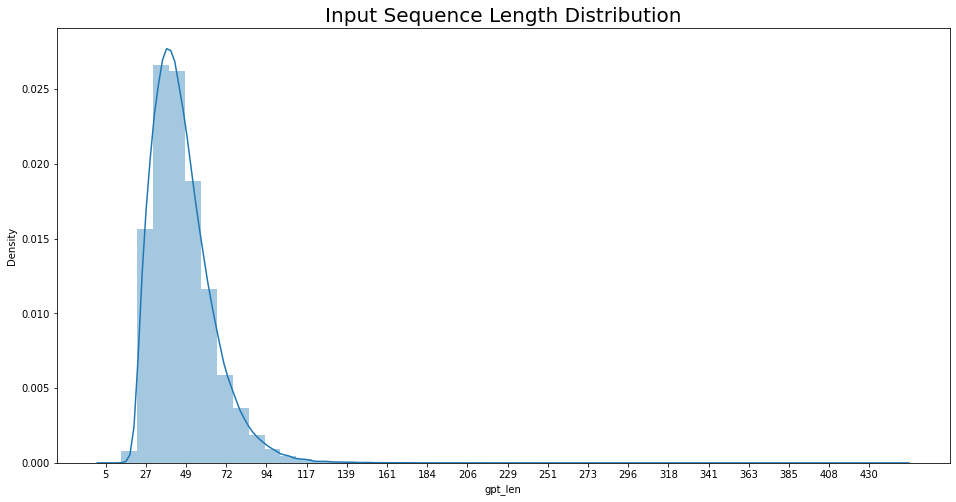

In [38]:
plt.rcParams["figure.figsize"] = (16,8)
plt.title("Input Sequence Length Distribution", fontsize=20)

gpt_len = data['gpt_len']
sns.distplot(gpt_len)
x_range = get_range(gpt_len, split=20)
plt.xticks(x_range, \
           ["{}".format(int(x)) for x in x_range])
plt.show()

싱글턴 데이터셋을 학습할 때, tokenizer의 max_len을 128로 설정